In [128]:
# Import common libraries
import pandas as pd
import numpy as np
from copy import deepcopy
import importlib


# Import MNE processing
from mne.viz import plot_compare_evokeds
from mne import Epochs, events_from_annotations, set_log_level
from mne_nirs.visualisation import plot_glm_group_topo

# Scikit Learn
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Import StatsModels
import statsmodels.formula.api as smf

# Import Plotting Library
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from mne_nirs.statistics import run_glm
import matplotlib as mpl

# Internal Packages
import analysis_tools
import system_file_io
import quality_eval
import dynamic_interval_tools
import glm_analysis
import visualizations

# Reset the cache
importlib.reload(analysis_tools)
importlib.reload(system_file_io)
importlib.reload(dynamic_interval_tools)
importlib.reload(glm_analysis)
importlib.reload(visualizations)

<module 'visualizations' from '/Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/visualizations.py'>

In [129]:
# ------------------------------------------------------------------
# Recurring values that we will allow for users to change in the GUI
# ------------------------------------------------------------------

# Length of the measured interval
interval_length = 15

# Time from trigger point being evaluated
# tmin = -1
# tmax = 15

# How you would like to rename the numeric triggers from Aurora
trigger_id = {'4': 'Control', '2': 'Neutral', '3': 'Inflam', '1':'Practice'}

# What files would you like to ignore while looping through subjects
ignore = [".DS_Store", "sub-03"]

# File path to the folder containing the BIDS data.
root_dir = '../../LabResearch/IndependentStudy/DataAnalysis'

# Mock data folder to test pulling meta data from folder structure.
path = "../../LabResearch/IndependentStudy/Data"

# Does the study have variable task lengths or does the study follow a block design?
variable_epoch_time = True

# Specifies what columns to use for the GLM constrast. If None, contrast is skipped
# Only two columns can be specified
columns_for_glm_contrast = ['Neutral', 'Inflam']

# Specifies what columns to use for group level analysis.
columns_for_group_analysis = ['Neutral', 'Inflam', 'Control']

In [130]:

def run_group_analysis(path, ignore, variable_epoch_time, columns_for_glm_contrast, columns_for_group_analysis, tmin=None, tmax=None):
    # Establish the groups, subject names, and snirf file paths for all subjects
    groups, df = system_file_io.import_data_folder(path, ignore)
    # run the analysis for each group
    glm_dataframes = {}
    for group in groups:
        paths = df[df.eq(group).any(1)]['snirf_path'].to_numpy()

        # Processes all Epochs with proper timestamps and collects it in all_epochs
        # all_data is dict of epoch, condition, raw_haemo, raw_intensity, and f_path for all subs
        all_epochs, all_data = analysis_tools.aggregate_epochs(paths=paths, trigger_id=trigger_id, variable_epoch_time = variable_epoch_time)

        # Process the GLM for all participants in the group into a list of design matrixes
        glm_data = glm_analysis.create_design_matrix(all_data, tmin, tmax)

        # Converts the glm design matrixes into a dataframe
        df_cha, df_con = glm_analysis.create_glm_df(glm_data, columns_for_glm_contrast)

        # Find the groups significant channels
        significant_channels = analysis_tools.find_significant_channels(df_cha)

        glm_dataframes[group] = {"channels_df": df_cha, "contrasts_df": df_con, "significant_channels": significant_channels, "all_data": all_data}
        
    return glm_dataframes

In [131]:
def run_individual_analysis(path, ignore, variable_epoch_time, columns_for_glm_contrast, columns_for_group_analysis, tmin=None, tmax=None):
    groups, df = system_file_io.import_data_folder(path, ignore)
    # run the analysis for each group
    glm_dataframes = {}

    paths = df[df.any(1)]['snirf_path'].to_numpy()

    for id, path in enumerate(paths):
        # Processes all Epochs with proper timestamps and collects it in all_epochs
        # all_data is dict of epoch, condition, raw_haemo, raw_intensity, and f_path for all subs
        all_epochs, all_data = analysis_tools.aggregate_epochs(paths=[path], trigger_id=trigger_id, variable_epoch_time = variable_epoch_time)

        # Process the GLM for all participants in the group into a list of design matrixes
        glm_data = glm_analysis.create_design_matrix(all_data, tmin, tmax)

        # Converts the glm design matrixes into a dataframe
        df_cha, df_con = glm_analysis.create_glm_df(glm_data, columns_for_glm_contrast)

        # Find the groups significant channels
        significant_channels = analysis_tools.find_significant_channels(df_cha)

        glm_dataframes[f'sub-{id+1}'] = {"channels_df": df_cha, "contrasts_df": df_con, "significant_channels": significant_channels, "all_data": all_data}
        
    return glm_dataframes

In [132]:
group_data = run_group_analysis(path, ignore, variable_epoch_time, columns_for_glm_contrast, columns_for_group_analysis, tmin=tmin, tmax=tmax)
group_data

Loading /Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/../../LabResearch/IndependentStudy/Data/anon/sub-06/nirs/sub-06_task-AnonCom_nirs.snirf
Reading 0 ... 18357  =      0.000 ...  1804.493 secs...
Events [359   0   1]
[]
[]
[<Epochs |  1 events (all good), -1.25 - 47.5 sec, baseline -1.25 – 0 sec, ~170 kB, data loaded,
 'Practice': 1>]
[<Epochs |  1 events (all good), -1.25 - 47.5 sec, baseline -1.25 – 0 sec, ~170 kB, data loaded,
 'Practice': 1>]
[<Epochs |  1 events (all good), -1.25 - 47.5 sec, baseline -1.25 – 0 sec, ~170 kB, data loaded,
 'Practice': 1>, <Epochs |  1 events (all good), -1.25 - 47.5 sec, baseline -1.25 – 0 sec, ~170 kB, data loaded,
 'Practice': 1>]
[<Epochs |  1 events (all good), -1.25 - 47.5 sec, baseline -1.25 – 0 sec, ~170 kB, data loaded,
 'Practice': 1>, <Epochs |  1 events (all good), -1.25 - 47.5 sec, baseline -1.25 – 0 sec, ~170 kB, data loaded,
 'Practice': 1>]
[<Epochs |  1 events (all good), -1.25 - 47.5 sec, baseline -1.25 – 0 sec, ~170 kB, da

{'anon': {'channels_df': variable Condition    df           mse   p_value            se         t  \
  0          Control  41.0  1.732858e-11  0.017723  1.951074e-06 -2.470935   
  1           Inflam  41.0  1.732858e-11  0.514172  1.949191e-06 -0.658069   
  2          Neutral  41.0  1.732858e-11  0.219602  1.949475e-06  1.246649   
  3         Practice  41.0  1.732858e-11  0.226729  1.948336e-06 -1.227251   
  4         constant  41.0  1.732858e-11  0.806730  9.973465e-07  0.246234   
  ...            ...   ...           ...       ...           ...       ...   
  51403      drift_5  38.0  3.358008e-13  0.764509  4.188950e-06  0.301723   
  51404      drift_6  38.0  3.358008e-13  0.499899  4.145174e-06  0.681162   
  51405      drift_7  38.0  3.358008e-13  0.745477  4.118503e-06  0.326980   
  51406      drift_8  38.0  3.358008e-13  0.680340  4.094311e-06  0.415187   
  51407      drift_9  38.0  3.358008e-13  0.929713  4.073446e-06 -0.088793   
  
  variable         theta Source Detect

In [133]:
# individual_data = run_individual_analysis(path, ignore, variable_epoch_time, columns_for_glm_contrast, columns_for_group_analysis)
# individual_data

# Visualizations

['Control', 'Inflam']
0
1


/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


0
1


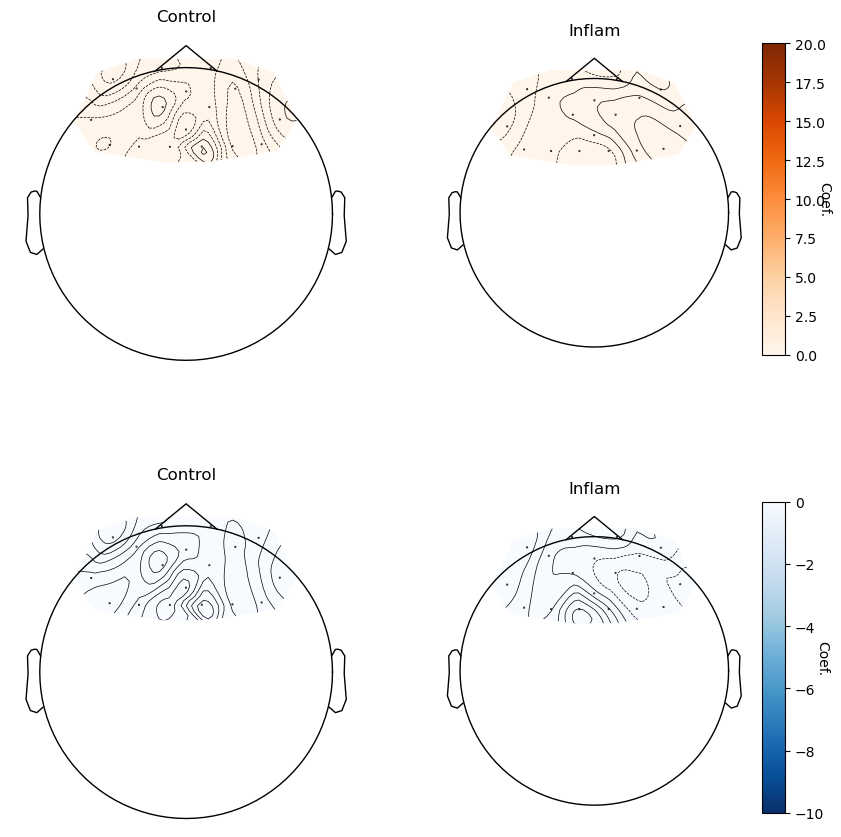

In [189]:
# Group Visualization
importlib.reload(visualizations)
columns_for_glm_contrast = ['Control', 'Inflam']

channels_df, contrasts_df, significant_channels, all_data = group_data['direct'].values()

raw_haemo = all_data[0]['raw_haemo']

visualizations.group_topological_visualisation(channels_df, columns_for_glm_contrast, raw_haemo)

['Condition', 'df', 'mse', 'p_value', 'se', 't', 'theta', 'Source', 'Detector', 'Chroma', 'Significant', 'ch_name']
Reducing GLM results to match MNE data


/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/mne_nirs/visualisation/_plot_GLM_topo.py:236: FutureWarning: reindexing with a non-unique Index is deprecated and will raise in a future version.
  statsmodel_df = statsmodel_df.reindex(info.ch_names)


ValueError: cannot reindex on an axis with duplicate labels

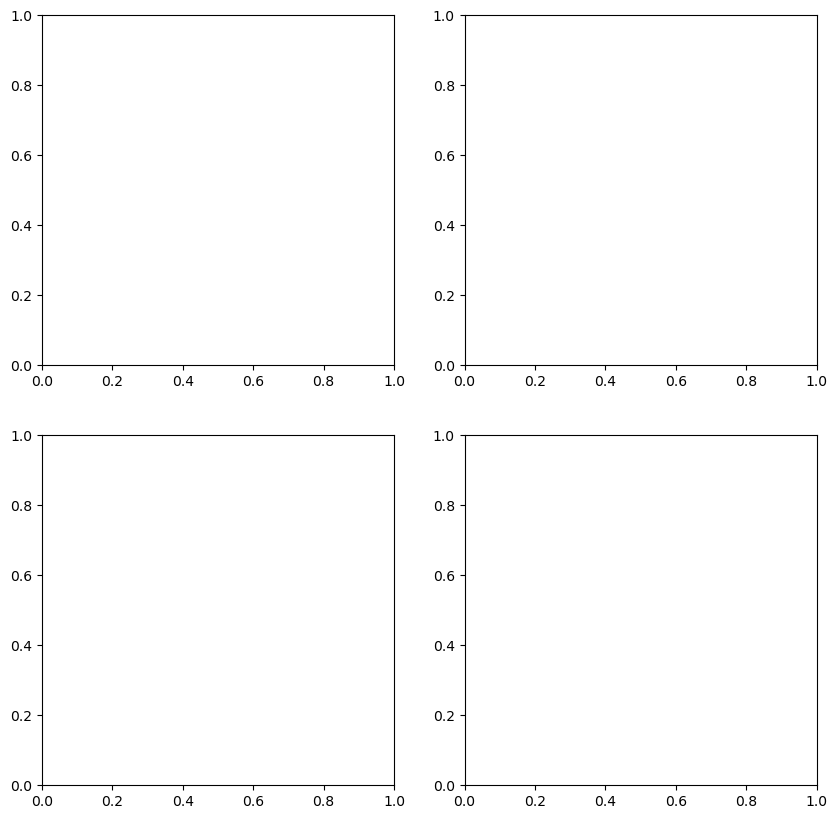

In [ ]:
grp_results = channels_df.query("Condition in ['Control', 'Tapping_Left', 'Tapping_Right']")
grp_results = grp_results.query("Chroma in ['hbo']")
print(grp_results.columns.tolist())
# print(channels_df)

# sns.catplot(x="theta", y="Condition", hue='Condition', data=grp_results, col_wrap=5, ci=None, palette="muted", height=4, s=10)

In [ ]:
# Individual Visualization
importlib.reload(visualizations)
channels_df, contrasts_df, significant_channels, all_data = individual_data['sub-1'].values()

raw_haemo = all_data[0]['raw_haemo']

visualizations.group_topological_visualisation(channels_df, columns_for_glm_contrast, raw_haemo)